In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random as ra
import torch.nn.functional as F
import math
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.patches as mpatches

import numpy as np
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import random as ra

In [3]:
input_size = 784        #Number of input neurons (image pixels, 28x28)
hidden_size0 = 32
hidden_size1 = 16      #Number of hidden neurons
out_size = 10           #Number of classes (0-9) 
epochs = 10            #How many times we pass our entire dataset into our network 
batch_size = 10000        #Input size of the data during one iteration 
learning_rate = 0.001   #How fast we are learning

In [4]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

next: use spatial relations of segments and networks activation patterns to extract rules

In [5]:
def reduce_img(img):
    img = img.squeeze(0)
    imp_pixels = (img > 0.5).nonzero(as_tuple=False)

    #pixel_count = img.view(-1).size()[0]
    pixel_count_important = (img > 0).sum().item()
    segment_size = round(pixel_count_important * 0.01, 0)

    #segment:
    clusterer = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=segment_size,
        linkage='complete',
        metric='euclidean'
    )
    labels = clusterer.fit_predict(imp_pixels)

    clusters = defaultdict(list)
    for coord, label in zip(imp_pixels, labels):
        clusters[label].append(coord)

    #making a map
    label_map = torch.zeros((28, 28), dtype=torch.int32)
    for label, coords in clusters.items():
        for coord in coords:
            y, x = coord.tolist()  # ensure unpacking from list of length 2
            label_map[y, x] = label + 1

    label_map_np = label_map.numpy()
    unique_vals = np.unique(label_map_np)

    #axs[1].imshow(label_map_np, cmap='inferno', interpolation='nearest')

    center_points = []
    for val in unique_vals:
        positions = np.argwhere(label_map_np == val)
        if positions.size == 0 or val == 0:
            continue
        centroid = positions.mean(axis=0)
        y, x = centroid
        center_points.append((int(round(y)), int(round(x))))
        #axs[1].text(x, y, str(val-1), color='lightgray', fontsize=20, ha='center', va='center')

    #print(center_points)
    return torch.tensor(center_points, dtype=torch.float32)

In [6]:
def neighbors_8(img, y, x):
    h, w = img.shape
    for ny in range(max(y-1,0), min(y+2,h)):
        for nx in range(max(x-1,0), min(x+2,w)):
            if (ny, nx) != (y, x):
                yield ny, nx

def find_primary_continuous_path(skeleton_image):
    if not np.any(skeleton_image):
        return []

    active_pixels = set(zip(*np.where(skeleton_image)))
    if not active_pixels:
        return []

    start_point = None
    for r, c in active_pixels:
        count = sum(1 for nr, nc in neighbors_8(skeleton_image, r, c) if skeleton_image[nr, nc])
        if count <= 1:
            start_point = (r, c)
            break
    if not start_point:
        start_point = next(iter(active_pixels))
        
    path = []
    visited = set()
    stack = [start_point]

    while stack:
        current_pixel = stack.pop()
        
        if current_pixel in visited:
            continue
        
        visited.add(current_pixel)
        path.append(current_pixel)

        unvisited_neighbors = []
        for ny, nx in neighbors_8(skeleton_image, *current_pixel):
            if skeleton_image[ny, nx] and (ny, nx) not in visited:
                unvisited_neighbors.append((ny, nx))
        
        for neighbor in unvisited_neighbors:
            stack.append(neighbor)

    return path

def bresenham_line(y0, x0, y1, x1):
    points = []
    dy = abs(y1 - y0)
    dx = abs(x1 - x0)
    sy = 1 if y0 < y1 else -1
    sx = 1 if x0 < x1 else -1
    err = dx - dy
    while True:
        points.append((y0, x0))
        if y0 == y1 and x0 == x1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points

def segment_only_on_white_pixels(start, end, skeleton):
    points_on_line = bresenham_line(start[0], start[1], end[0], end[1])
    return all(skeleton[y, x] != 0 for y, x in points_on_line)

def line_approximation_with_corners(path, angle_tolerance_degrees=20):
    segments = []
    if len(path) < 2:
        return segments

    current_segment_start_point = path[0]

    for i in range(1, len(path)):
        current_point_on_path = path[i]

        if i == len(path) - 1:
            if segment_only_on_white_pixels(current_segment_start_point, current_point_on_path, skeleton):
                segments.append((current_segment_start_point, current_point_on_path))
            break

        next_point_on_path = path[i + 1]

        v1 = np.array(current_point_on_path) - np.array(current_segment_start_point)
        v2 = np.array(next_point_on_path) - np.array(current_point_on_path)

        if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
            continue

        dot_product = np.dot(v1, v2)
        magnitude_v1 = np.linalg.norm(v1)
        magnitude_v2 = np.linalg.norm(v2)

        cos_theta = max(-1.0, min(1.0, dot_product / (magnitude_v1 * magnitude_v2)))

        angle_radians = math.acos(cos_theta)
        angle_degrees = math.degrees(angle_radians)

        is_corner = (angle_degrees > angle_tolerance_degrees and
                     angle_degrees < (180 - angle_tolerance_degrees))

        if is_corner or not segment_only_on_white_pixels(current_segment_start_point, current_point_on_path, skeleton):
            if segment_only_on_white_pixels(current_segment_start_point, current_point_on_path, skeleton):
                segments.append((current_segment_start_point, current_point_on_path))
            current_segment_start_point = current_point_on_path

    if current_segment_start_point != path[-1] or not segments:
        if len(path) > 1 and (not segments or segments[-1][1] != path[-1]):
            if segment_only_on_white_pixels(current_segment_start_point, path[-1], skeleton):
                segments.append((current_segment_start_point, path[-1]))

    return segments

In [7]:
inputs, labels = next(iter(train_loader))

modified_inputs = []

for i, img in enumerate(inputs):
    x = reduce_img(img)
    modified_inputs.append((x, labels[i]))

"""
import pickle

with open('modified_inputs.pkl', 'wb') as f:
    pickle.dump(modified_inputs, f)
    """

"\nimport pickle\n\nwith open('modified_inputs.pkl', 'wb') as f:\n    pickle.dump(modified_inputs, f)\n    "

In [8]:
"""import pickle

with open('modified_inputs.pkl', 'rb') as f:
    modified_inputs = pickle.load(f)"""

"import pickle\n\nwith open('modified_inputs.pkl', 'rb') as f:\n    modified_inputs = pickle.load(f)"

In [9]:
print(modified_inputs[ra.randint(0, 999)][1].item())

5


Idea: train each digit individually to determine its definition boundaries. For each digit, find consistent patterns.

In [10]:
check_dig = 3

for pair in modified_inputs:
    if pair[1].item() != check_dig:
        continue

    #find all spatial relations, keep consistent ones:
    #how to describe all relations: vector from each point to all others -> complete relations
    #find similar traits of those

    point_tensor = pair[0]
    vectors = []

    for point in point_tensor:
        pass
        



#ASSUMPTION MADE FOR THE FOLLOWING:

Since handwritting can vary a lot and still be recognized by humans and neural nets, yet still different digit exist, there must be a clear decision boundary.
This would imply that a handwritten digit is not defined in fixed coordinates, but the relation of different geometrical structures and concepts.
This lead me to assume that only the relations between enough points (coordinates) on the digit are enough for a digit to be identified correctly.
My hypothesis seems to have been proven right by the following, bigger than previous, FFN being able to achieve accuracies of ~0.9999%

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


MAX_POINTS = 50

def vectorize_points(points):
    N = points.shape[0]
    padded = torch.zeros((MAX_POINTS, 2))
    padded[:N] = points[:MAX_POINTS]
    diffs = padded.unsqueeze(1) - padded.unsqueeze(0)
    return padded.flatten()

X = []
y = []

for pts, label in modified_inputs:
    X.append(vectorize_points(pts)) #points on digit
    y.append(label)

X = torch.stack(X) #.view(10000, 800)
y = torch.tensor(y).long()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hidd_size0 = 512
hidd_size1 = 128

class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(MAX_POINTS * 2, hidd_size0),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidd_size0, hidd_size1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidd_size1, 10)
        )

    def forward(self, x):
        return self.net(x)

model = FFN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5000):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_out = model(X_test)
        test_pred = test_out.argmax(dim=1)
        test_acc = (test_pred == y_test).float().mean()
    print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Test Acc: {test_acc.item():.4f}")


#torch.save(model.state_dict(), 'model.pth')


#model.load_state_dict(torch.load('model.pth'))

Epoch 0 | Loss: 5.0209 | Test Acc: 0.1040
Epoch 1 | Loss: 3.6685 | Test Acc: 0.0965
Epoch 2 | Loss: 3.7249 | Test Acc: 0.1255
Epoch 3 | Loss: 3.5574 | Test Acc: 0.1370
Epoch 4 | Loss: 3.3471 | Test Acc: 0.1245
Epoch 5 | Loss: 3.0557 | Test Acc: 0.1200
Epoch 6 | Loss: 2.7783 | Test Acc: 0.1160
Epoch 7 | Loss: 2.5857 | Test Acc: 0.1225
Epoch 8 | Loss: 2.4282 | Test Acc: 0.1215
Epoch 9 | Loss: 2.3618 | Test Acc: 0.1165
Epoch 10 | Loss: 2.3211 | Test Acc: 0.1160
Epoch 11 | Loss: 2.3061 | Test Acc: 0.1030
Epoch 12 | Loss: 2.3029 | Test Acc: 0.0910
Epoch 13 | Loss: 2.2997 | Test Acc: 0.0950
Epoch 14 | Loss: 2.2990 | Test Acc: 0.0945
Epoch 15 | Loss: 2.2971 | Test Acc: 0.0960
Epoch 16 | Loss: 2.2997 | Test Acc: 0.0935
Epoch 17 | Loss: 2.2973 | Test Acc: 0.1010
Epoch 18 | Loss: 2.2967 | Test Acc: 0.1020
Epoch 19 | Loss: 2.2963 | Test Acc: 0.1040
Epoch 20 | Loss: 2.2947 | Test Acc: 0.1090
Epoch 21 | Loss: 2.2915 | Test Acc: 0.1090
Epoch 22 | Loss: 2.2891 | Test Acc: 0.1250
Epoch 23 | Loss: 2.28

KeyboardInterrupt: 

In [12]:
inputs1, labels1 = next(iter(test_loader))

test_inputs = []
for i, img in enumerate(inputs1):
    x = reduce_img(img)
    test_inputs.append((x, labels1[i]))

print(len(test_inputs)) #10'000

10000


In [13]:
X_test = []
y_test = []

for pts, label in test_inputs:
    X_test.append(vectorize_points(pts))
    y_test.append(label)

X_test = torch.stack(X_test).view(10000, 200)
y_test = torch.tensor(y_test).long()

model.eval()
with torch.no_grad():
    test_out = model(X_test)
    test_loss = criterion(test_out, y_test)
    test_acc = (test_out.argmax(dim=1) == y_test).float().mean()
    print(f"Test Loss: {test_loss.item():.4f} | Test Acc: {test_acc.item():.4f}")
model.train()


RuntimeError: shape '[10000, 200]' is invalid for input of size 1000000

In [14]:
def fit_points(points):
    N = points.shape[0]
    padded = torch.zeros((MAX_POINTS, 2))
    padded[:N] = points[:MAX_POINTS]

    return padded


idx = ra.randint(0, len(test_inputs) - 1)
example_pts, example_label = test_inputs[idx]

testex = torch.tensor([[14, 14],
        [19,  8],
        [22, 10],
        [16, 11],
        [18, 16],
        [ 6, 14],
        [12,  9],
        [22, 16],
        [ 9, 15],
        [ 7, 10]])

example_vec = vectorize_points(example_pts).unsqueeze(0).view(-1, 200)
model.eval()
with torch.no_grad():
    prediction = model(example_vec) #example_vec.argmax(dim=1).item()



example_pts = fit_points(example_pts)
centroids = torch.zeros((28, 28), dtype=torch.int32)
for i in range(len(example_pts)):
    centroids[int(example_pts[i][0].item()), int(example_pts[i][1].item())] = 255



plt.imshow(centroids, cmap="gray")
plt.title(f"Predicted: {prediction}\n\nPrediction: {prediction.argmax(dim=1).item()} | Label: {example_label.item()}")
plt.show()

RuntimeError: shape '[-1, 200]' is invalid for input of size 100

In [15]:
#next: extract spatial rules from bigger FFN, to define decision boundaries and explain criteria for a digit.
#idea: start with only 4 and 9, define margin between 4 and 9, might be easier due to existing similarity

I basically traded input complexity for model complexity

I have abstracted my input in such a way that the model needs to do more and be more complex, which doesn't hurt complexity of my approach, instead it helps because the input is now reduced (simplified and abstracted) so much that finding decision boundaries with fewer changes in input is possible. The plan is to use these to define and further abstract geometrical relations, to ultimately find the geometrical "criteria" that my FFNs have learnt to identify digits, and to therein find an explanation and reasoning for why human brains can so simply explain how a digit is identified (though not necessarily how it is defined)

If successful, I can also explain why internal and local decisions of my FFN happen, by identifying the exact difference and limits/boundaries in the input - the input is where to look first and humans also don't look at every pixel explicitely when reasoning about what digit it is

In [ ]:
#also possible: I can search the 200D input space with gradient based search to find class boundaries

In [ ]:
import pygame

pygame.init()
w, h = 800, 550
cell = 16
grid_off = (50, 50)
grid_size = 28
num_points = 10

screen = pygame.display.set_mode((w, h))
points = [tuple((pair[0]-5, pair[1]-5)) for pair in example_pts.tolist()] #[(ra.randint(0, 27), ra.randint(0, 27)) for i in range(num_points)]
drag_idx = None
font = pygame.font.SysFont(None, 36)
saved = False
pred = None

def draw():
    global pred
    screen.fill((0, 0, 0))
    #grid
    for i in range(grid_size+1):
        pygame.draw.line(screen, (255, 255, 255),
                        (grid_off[0], grid_off[1]+i*cell),
                        (grid_off[0]+grid_size*cell, grid_off[1]+i*cell))
        pygame.draw.line(screen, (255, 255, 255),
                        (grid_off[0]+i*cell, grid_off[1]),
                        (grid_off[0]+i*cell, grid_off[1]+grid_size*cell))
    #points
    for r, c in points:
        rect = pygame.Rect(grid_off[0]+c*cell, grid_off[1]+r*cell, cell, cell)
        pygame.draw.rect(screen, (255, 255, 255), rect)
    if saved:
        txt = font.render(f"{pred}", True, (255, 255, 255))
        screen.blit(txt, (grid_off[0] + grid_size*cell + 20, h//2))
    pygame.display.flip()

def pos_to_cell(pos):
    x, y = pos
    col = (x - grid_off[0]) // cell
    row = (y - grid_off[1]) // cell
    if 0 <= col < grid_size and 0 <= row < grid_size:
        return (row, col)
    return None

running = True
while running:
    draw()
    for e in pygame.event.get():
        if e.type == pygame.QUIT:
            running = False
        elif e.type == pygame.MOUSEBUTTONDOWN and e.button == 1:
            cell_pos = pos_to_cell(e.pos)
            if cell_pos and cell_pos in points:
                drag_idx = points.index(cell_pos)
        elif e.type == pygame.MOUSEBUTTONUP and e.button == 1:
            drag_idx = None
        elif e.type == pygame.MOUSEMOTION and drag_idx is not None:
            cell_pos = pos_to_cell(e.pos)
            if cell_pos and cell_pos not in points:
                points[drag_idx] = cell_pos
        elif e.type == pygame.KEYDOWN and e.key == pygame.K_s:
            coords = torch.tensor(points)

            print(coords)
            
            coords = vectorize_points(coords).unsqueeze(0).view(-1, 200)

            model.eval()
            with torch.no_grad():
                pred = model(coords).argmax(dim=1).item()
    
            print("Prediction of Model:", pred)
            saved = True

pygame.quit()


pygame 2.6.1 (SDL 2.28.4, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/kns357/Desktop/ann_ma_kaito/venv0/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


NameError: name 'example_pts' is not defined

In [ ]:
from captum.attr import LRP

Text(0.5, 1.0, 'average pixels per digit')

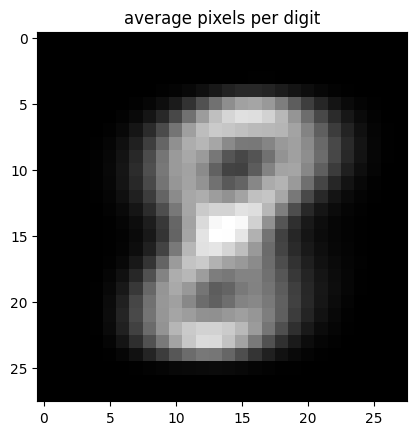

In [ ]:
accumulator = np.zeros((1, 28, 28), dtype=np.float64)
bin_digit = ra.randint(0, 9)
count = 0
for img, label in train_dataset:
    if label == bin_digit:
        img = img.numpy()
        arr = np.array(img, dtype=np.float64)
        accumulator += arr
        count += 1

average_img = (accumulator / count).squeeze()
plt.imshow(average_img, cmap="gray")
plt.title("average pixels per digit")

In [ ]:

ind = ra.randrange(0, len(test_inputs)-1)


for ind in range(10):
    example_pts, example_label = test_inputs[ind]
    input = vectorize_points(example_pts).unsqueeze(0)

    #input = inputs[ind].unsqueeze(0).cuda()
    #input.requires_grad_()

    label = labels[ind].item()

    model.eval()
    with torch.no_grad():
        output = model(input).argmax(dim=1)
        #output = model(input)
        prob = torch.sigmoid(output)
        prediction = (prob >= 0.5).int().item()



    lrp = LRP(model)
    target = torch.tensor(0).cuda() #which neuron, there is only one

    attributions = lrp.attribute(input, target=target)

    rel_map = attributions[0].cpu().detach().numpy().reshape(10, 2)

    with torch.no_grad():
        input_np = input[0].cpu().numpy().reshape(10, 2)  #input image

    background_mask = (input_np == 0)

    min_val = rel_map.min()

    rel_map[background_mask] = min_val

    rel_map = np.maximum(rel_map, 0)

    #normalise:
    rel_max = rel_map.max()
    rel_map /= rel_max

    average_max = average_img.max()
    average_img / average_max

    #get overlaps with average bin_digit:
    #mat_diff = 1 - (rel_map-average_img)
    #mat_avg = (abs(rel_map) + abs(average_img)) / 2
    #mat_diff *= -(mat_avg)


    centroids = torch.zeros((28, 28), dtype=torch.int32)
    for i in range(len(input)):
        centroids[int(input[i][0].item()), int(input[i][1].item())] = 255


    mat_overlap =  centroids * average_img #rel_map * average_img

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(rel_map, cmap='gray', interpolation='nearest')
    prediction = 1 - prediction
    ax1.set_title(f"LRP relevance map for output neuron {target.item()}\nLabel: {label} | Prediction:{' not'*prediction} {bin_digit}")
    ax1.axis('off')

    ax2.imshow(average_img, cmap="gray")
    ax2.axis('off')

    ax3.imshow(mat_overlap, cmap='gray', interpolation='nearest')
    ax3.axis('off')

    fig.colorbar(ax1.images[0], ax=[ax1, ax2, ax3], orientation='vertical', fraction=0.05)

    #plt.tight_layout()
    plt.show()




RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x2 and 200x512)

Time: 0:00:00.000109


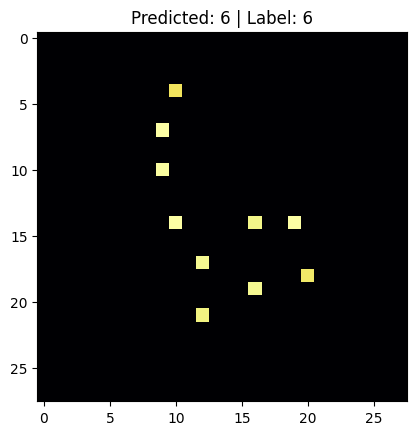

In [ ]:
weights = model.net[0].weight.detach().cpu()
importance = weights.abs().sum(dim=0).view(10, 2)

from datetime import datetime

def fit_points(points):
    N = points.shape[0]
    padded = torch.zeros((MAX_POINTS, 2))
    padded[:N] = points[:MAX_POINTS]

    return padded

idx = ra.randint(0, len(test_inputs) - 1)
example_pts, example_label = test_inputs[idx]

example_vec = vectorize_points(example_pts).unsqueeze(0)
model.eval()
with torch.no_grad():
    t0 = datetime.now()
    prediction = model(example_vec).argmax(dim=1).item()
    t1 = datetime.now()

print(f"Time: {t1-t0}")

example_pts = fit_points(example_pts)
centroids = torch.zeros((28, 28), dtype=torch.int32)
for i in range(len(example_pts)):
    centroids[int(example_pts[i][0].item()), int(example_pts[i][1].item())] = importance[i][0].item() + importance[i][1].item()

plt.imshow(centroids, cmap="inferno")
plt.title(f"Predicted: {prediction} | Label: {example_label.item()}")
plt.show()


In [ ]:
#all pixles are about the same importance, only 20 coordinates, every single one matters!

#gradient-based counterfactuals: https://arxiv.org/pdf/2205.07774

In [ ]:
from torch.autograd import Variable

In [ ]:
x = Variable(torch.tensor(example_pts, dtype=torch.float32), requires_grad=True)
#original = 5
#target = 7

#basically points x initialised as input labelled one class, and then optimized to be labelled another class

def cf_loss(x, model, orig_class, targ_class):
    logits = model(x)
    return -logits[targ_class] + logits[orig_class]

optimizer = torch.optim.Adam([x], lr=0.1)
cfs_list = []

for original in range(10):
    for target in range(10): #sorry for the ugly nesting
        if original == target:
            continue
        for i in range(1000): #probably finished sooner
            x = x.reshape(-1)
            optimizer.zero_grad()
            loss = cf_loss(x, model, orig_class=original, targ_class=target)
            loss.backward()
            optimizer.step()
            if model(x).argmax().item() == target:
                print(f"reached: idx {i}")
                break

    counterfactual = x.detach().numpy()
    cfs_list.append(np.concatenate([counterfactual, [original, target]])) #apparently more efficient than vstack, doing vstack once after loop

cfs = np.array(cfs_list)
cfs.shape

reached: idx 47
reached: idx 107
reached: idx 41
reached: idx 23
reached: idx 80
reached: idx 37
reached: idx 44
reached: idx 65
reached: idx 8


/tmp/ipykernel_112150/296314372.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = Variable(torch.tensor(example_pts, dtype=torch.float32), requires_grad=True)


reached: idx 27
reached: idx 8
reached: idx 21
reached: idx 44
reached: idx 34
reached: idx 615
reached: idx 0
reached: idx 80
reached: idx 880
reached: idx 0
reached: idx 77
reached: idx 0
reached: idx 0


(10, 22)

In [ ]:
#the idea is that humans can't focus on 784 different points with scattered atention across the entire image at once, which is why input reduction is a key process, consdiering lack of accuracy drop

#bridging gaps between local explanations and global boundary understanding by mapping prediction changes to specific neuron activations internally -> explain which neurons activate on which features and attribute features to class, according to net!

In [ ]:
import numpy as np

#Convert the original input into array if not already
x0 = np.array(example_pts).flatten()  # shape (20,)

#Convert to array for fast slicing
cfs_array = np.array(cfs_list)  # shape (n_samples, 22) with last 2 = [orig, target]

deltas = []
x0s = []
xcf_list = []
labels = []

for row in cfs_array:
    xcf = row[:20]
    orig_class, target_class = int(row[20]), int(row[21])
    
    delta = xcf - x0  #∆x ∈ ℝ²⁰

    deltas.append(delta)
    x0s.append(x0)
    xcf_list.append(xcf)
    labels.append((orig_class, target_class))


In [ ]:
#Total movement magnitude (L2 norm of full ∆x)
delta_norms = np.linalg.norm(deltas, axis=1)  #shape (n_samples,)

#Per-point movement magnitude (L2 norm of each point)
delta_points = np.reshape(deltas, (-1, 10, 2))  #shape (n_samples, 10, 2)
point_norms = np.linalg.norm(delta_points, axis=2)  #shape (n_samples, 10)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
deltas_reduced = pca.fit_transform(deltas)


In [ ]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(deltas_reduced)

cluster_centers = kmeans.cluster_centers_


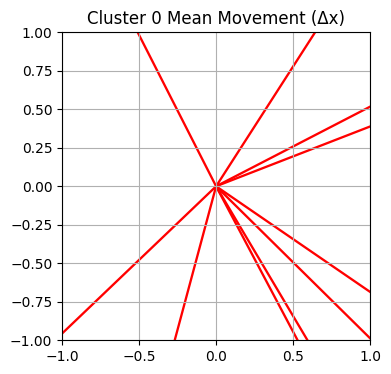

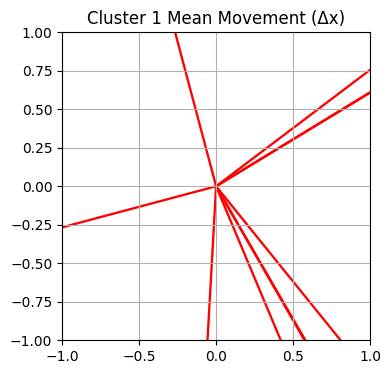

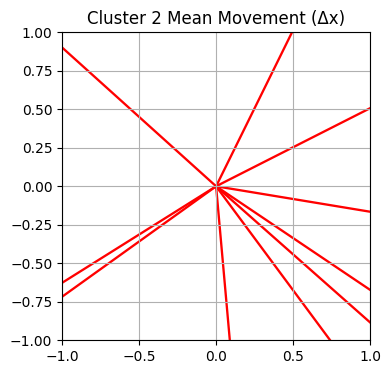

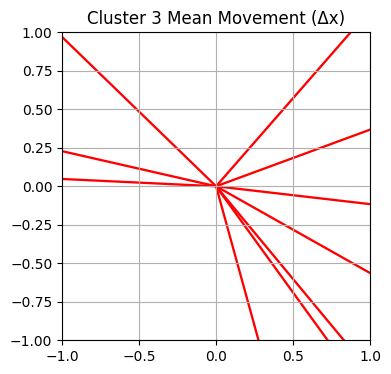

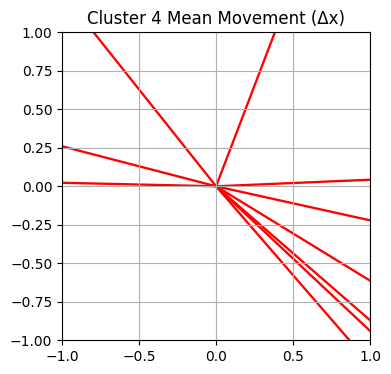

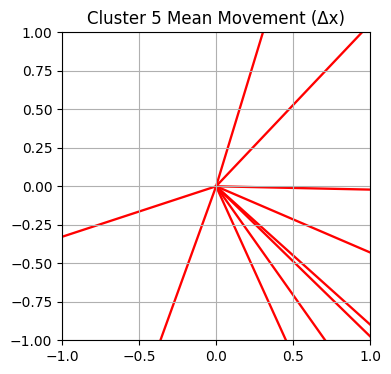

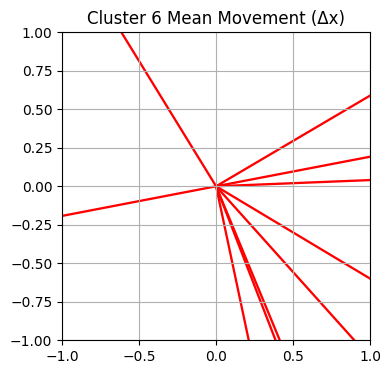

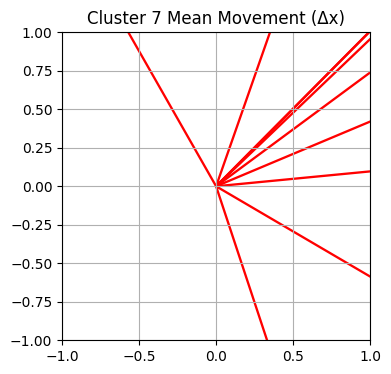

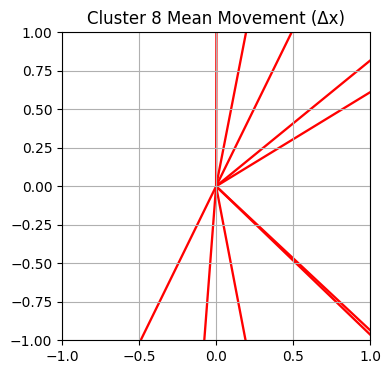

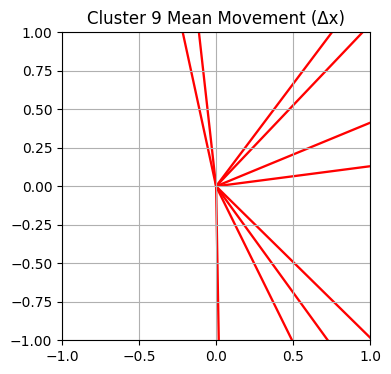

In [ ]:
import matplotlib.pyplot as plt

for clust_id in range(k):
    indices = np.where(cluster_labels == clust_id)[0]
    if len(indices) == 0:
        continue

    avg_delta = np.mean([deltas[i] for i in indices], axis=0)
    avg_delta_pts = avg_delta.reshape(10, 2)

    plt.figure(figsize=(4, 4))
    plt.title(f"Cluster {clust_id} Mean Movement (Δx)")
    plt.quiver(np.zeros(10), np.zeros(10),
               avg_delta_pts[:, 0], avg_delta_pts[:, 1],
               angles='xy', scale_units='xy', scale=1, color='r')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.show()


In [ ]:
from collections import Counter

for clust_id in range(k):
    indices = np.where(cluster_labels == clust_id)[0]
    pair_counts = Counter([labels[i] for i in indices])
    most_common = pair_counts.most_common(1)[0][0]
    print(f"Cluster {clust_id}: most common transition {most_common[0]} → {most_common[1]}")


Cluster 0: most common transition 5 → 9
Cluster 1: most common transition 2 → 9
Cluster 2: most common transition 8 → 9
Cluster 3: most common transition 9 → 9
Cluster 4: most common transition 7 → 9
Cluster 5: most common transition 6 → 9
Cluster 6: most common transition 4 → 9
Cluster 7: most common transition 0 → 9
Cluster 8: most common transition 1 → 9
Cluster 9: most common transition 3 → 9


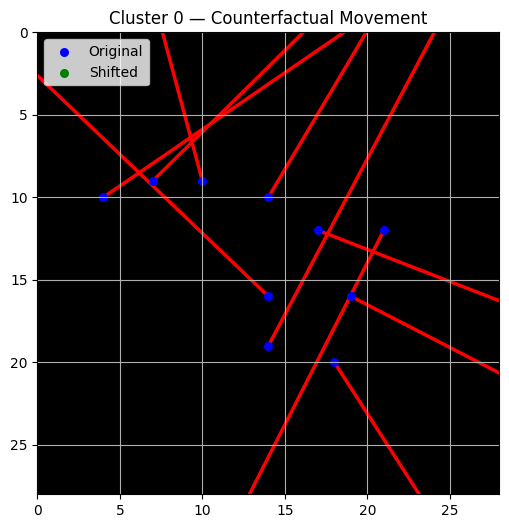

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cluster_id = 0
indices = np.where(cluster_labels == cluster_id)[0]
avg_delta = np.mean([deltas[i] for i in indices], axis=0).reshape(10, 2)
x0_points = np.array(x0).reshape(10, 2)  # original input positions

x1_points = x0_points + avg_delta

fig, ax = plt.subplots(figsize=(6, 6))
img = np.zeros((28, 28))

ax.imshow(img, cmap='gray', extent=(0, 28, 28, 0))  # flip Y to match image
ax.set_title(f"Cluster {cluster_id} — Counterfactual Movement")

ax.quiver(
    x0_points[:, 0], x0_points[:, 1],                  # starting points
    avg_delta[:, 0], avg_delta[:, 1],                  # movement vectors
    angles='xy', scale_units='xy', scale=1, color='red'
)

ax.scatter(x0_points[:, 0], x0_points[:, 1], color='blue', label='Original', s=30)
ax.scatter(x1_points[:, 0], x1_points[:, 1], color='green', label='Shifted', s=30)

ax.set_xlim(0, 28)
ax.set_ylim(28, 0)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.show()
